# TP: MNIST with Neural Networks (NN)

#### Lab done by student : Iqbi Hamza & Daria Taha

In [1]:
import numpy as np
import tensorflow as tf
import keras
from keras.datasets import mnist
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import SGD

from sklearn.decomposition import PCA

print("Using tensorflow version " + str(tf.__version__))
print("Using keras version " + str(keras.__version__))

Using tensorflow version 2.11.0
Using keras version 2.11.0


## Loading and preparing the MNIST dataset
Load the MNIST dataset made available by keras.datasets. Check the size of the training and testing sets. 

<div class='alert alert-block alert-info'>
            Code:</div>

In [2]:
# The MNSIT dataset is ready to be imported from Keras into RAM
# Warning: you cannot do that for larger databases (e.g., ImageNet)
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# size of the data
print("Size of the training set: " + str(train_images.shape))
print("Size of the test set: " + str(test_images.shape))


Size of the training set: (60000, 28, 28)
Size of the test set: (10000, 28, 28)


The MNIST database contains 60,000 training images and 10,000 testing images.
Using the pyplot package, visualize the first sample of the training set:

<div class='alert alert-block alert-info'>
            Code:</div>

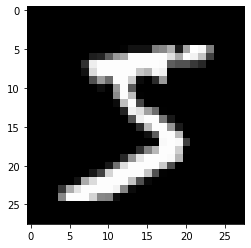

In [3]:
# Let us visualize the first training sample using the Matplotlib library with the imshow function
from matplotlib import pyplot as plt
plt.imshow(train_images[0],cmap='gray')
plt.show()

The database contains images of handwritten digits. Hence, they belong to one of 10 categories, depending on the digit they represent. 
Reminder: in order to do multi-class classification, we use the softmax function, which outputs a multinomial probability distribution. That means that the output to our model will be a vector of size $10$, containing probabilities (meaning that the elements of the vector will be positive sum to $1$).
For easy computation, we want to true labels to be represented with the same format: that is what we call **one-hot encoding**. For example, if an image $\mathbf{x}$ represents the digit $5$, we have the corresponding one_hot label (careful, $0$ will be the first digit): 
$$ \mathbf{y} = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0] $$
Here, you need to turn train and test labels to one-hot encoding using the following function: 

<div class='alert alert-block alert-info'>
            Code:</div>

In [4]:
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

Images are black and white, with size $28 \times 28$. We will work with them using a simple linear classification model, meaning that we will have them as vectors of size $(784)$.
You should then transform the images to the size $(784)$ using the numpy function ```reshape```.

Then, after casting the pixels to floats, normalize the images so that they have zero-mean and unitary deviation. Be careful to your methodology: while you have access to training data, you may not have access to testing data, and must avoid using any statistic on the testing dataset.

<div class='alert alert-block alert-info'>
            Code:</div>

In [5]:
# Reshape images to vectors of pixels
img_rows, img_cols = train_images.shape[1], train_images.shape[2]
print(train_images.shape)
train_images = train_images.reshape(train_images.shape[0], img_rows * img_cols)
print(train_images.shape)
test_images = test_images.reshape(test_images.shape[0], img_rows * img_cols)


# Cast pixels from uint8 to float32
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# Now let us normalize the images so that they have zero mean and standard deviation
# Hint: are real testing data statistics known at training time ?
mean = np.mean(train_images)
std = np.std(train_images)
train_images = (train_images - mean) / std
test_images = (test_images - mean) / std

(60000, 28, 28)
(60000, 784)


# First part: working with Numpy

Look at this [cheatsheet](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Numpy_Python_Cheat_Sheet.pdf) for some basic information on how to use numpy.

### Defining the model 

We will here create a simple, linear classification model. We will take each pixel in the image as an input feature (making the size of the input to be $784$) and transform these features with a weight matrix $\mathbf{W}$ and a bias vector $\mathbf{b}$. Since there is $10$ possible classes, we want to obtain $10$ scores. Then, 
$$ \mathbf{W} \in \mathbb{R}^{784 \times 10} $$
$$ \mathbf{b} \in \mathbb{R}^{10} $$

and our scores are obtained with:
$$ \mathbf{z} = \mathbf{W}^{T} \mathbf{x} +  \mathbf{b} $$

where $\mathbf{x} \in \mathbb{R}^{784}$ is the input vector representing an image.
We note $\mathbf{y} \in \mathbb{R}^{10}$ as the target one_hot vector. 

Here, you fist need to initialize $\mathbf{W}$ and $\mathbf{b}$ using ```np.random.normal``` and ```np.zeros```, then compute $\mathbf{z}$.
<div class='alert alert-block alert-info'>
            Code:</div>

In [6]:
# To avoid implementing a complicated gradient back-propagation,
# we will try a very simple architecture with one layer 
def initLayer(n_input,n_output):
    """
    Initialize the weights, return the number of parameters
    Inputs: n_input: the number of input units - int
          : n_output: the number of output units - int
    Outputs: W: a matrix of weights for the layer - numpy ndarray
           : b: a vector bias for the layer - numpy ndarray
           : nb_params: the number of parameters  - int
    """
    
    # Create W at the right size with a normal distribution
    W = np.random.normal(0,1,(n_input,n_output))
    # Create b at the right size, with zeros
    b = np.zeros((1,n_output))
    nb_params = n_input*n_output + n_output
    return W, b, nb_params

In [7]:
n_training = train_images.shape[0] 
n_feature =  train_images.shape[1]
n_labels = 10
W, b, nb_params = initLayer(n_feature, n_labels)

<div class='alert alert-block alert-info'>
            Code:</div>

In [8]:
def forward(W, b, X):
    """
    Perform the forward propagation
    Inputs: W: the weights - numpy ndarray
          : b: the bias - numpy ndarray
          : X: the batch - numpy ndarray
    Outputs: z: outputs - numpy ndarray
    """
    z = np.dot(X,W) + b
    return z

### Computing the output 

To obtain classification probabilities, we use the softmax function:
$$ \mathbf{o} = softmax(\mathbf{z}) \text{         with          } o_i = \frac{\exp(z_i)}{\sum_{j=0}^{9} \exp(z_j)} $$

The usual difficulty with the softmax function is the possibility of overflow when the scores $z_i$ are already large. Since a softmax is not affected by a shift affecting the whole vector $\mathbf{z}$:
$$ \frac{\exp(z_i - c)}{\sum_{j=0}^{9} \exp(z_j - c)} =  \frac{\exp(c) \exp(z_i)}{\exp(c) \sum_{j=0}^{9} \exp(z_j)} = \frac{\exp(z_i)}{\sum_{j=0}^{9} \exp(z_j)}$$
what trick can we use to ensure we will not encounter any overflow ? 
<div class='alert alert-block alert-info'>
            Code:</div>

In [9]:
def softmax(z):
    """
    Perform the softmax transformation to the pre-activation values
    Inputs: z: the pre-activation values - numpy ndarray
    Outputs: out: the activation values - numpy ndarray
    """
    # use a trick to avoid numerical overflow by shifting the values
    out = np.exp(z - np.max(z)) / np.sum(np.exp(z - np.max(z)), axis=1, keepdims=True)

    return out

### Making updates

We define a learning rate $\eta$. The goal is to be able to apply updates:
$$ \mathbf{W}^{t+1} = \mathbf{W}^{t} + \nabla_{\mathbf{W}} l_{MLE} $$

In order to do this, we will compute this gradient (and the bias) in the function ```update```. In the next function ```updateParams```, we will actually apply the update with regularization. 

Reminder: the gradient $\nabla_{\mathbf{W}} l_{MLE}$ is the matrix containing the partial derivatives 
$$ \left[\frac{\delta l_{MLE}}{\delta W_{ij}}\right]_{i=1..784, j=1..10} $$
**Remark**: Careful, the usual way of implementing this in python has the dimensions of $\mathbf{W}$ reversed compared to the notation of the slides.

Coordinate by coordinate, we obtain the following update: 
$$ W_{ij}^{t+1} = W_{ij}^{t} + \eta \frac{\delta l_{MLE}}{\delta W_{ij}} $$

Via the chain rule, we obtain, for an input feature $i \in [0, 783]$ and a output class $j \in [0, 9]$: $$\frac{\delta l_{MLE}}{\delta W_{ij}} = \frac{\delta l_{MLE}}{\delta z_{j}} \frac{\delta z_j}{\delta W_{ij}}$$ 

It's easy to compute that $\frac{\delta z_j}{\delta W_{ij}} = x_i$

We compute the softmax derivative, to obtain:
$$ \nabla_{\mathbf{z}} l_{MLE} = \mathbf{o} - \mathbf{y} $$

Hence, $\frac{\delta l_{MLE}}{\delta z_{j}} = o_j - y_j$ and we obtain that $$\frac{\delta l_{MLE}}{\delta W_{ij}} = (o_j - y_j) x_i$$

This can easily be written as a scalar product, and a similar computation (even easier, actually) can be done for $\mathbf{b}$. Noting $\nabla_{\mathbf{z}} l_{MLE} = \mathbf{o} - \mathbf{y}$ as ```grad``` in the following function, compute the gradients $\nabla_{\mathbf{W}} l_{MLE}$ and $\nabla_{\mathbf{b}} l_{MLE}$ in order to call the function ```updateParams```.

Note: the regularizer and the weight_decay $\lambda$ are used in ```updateParams```.

<div class='alert alert-block alert-info'>
            Code:</div>

In [10]:
def update(eta, W, b, grad, X, regularizer, weight_decay):
    """
    Perform the update of the parameters
    Inputs: eta: the step-size of the gradient descent - float 
          : W: the weights - ndarray
          : b: the bias -  ndarray
          : grad: the gradient of the activations w.r.t. to the loss -  list of ndarray
          : X: the data -  ndarray
          : regularizer: 'L2' or None - the regularizer to be used in updateParams
          : weight_decay: the weight decay to be used in updateParams - float
    Outputs: W: the weights updated -  ndarray
           : b: the bias updated -  ndarray
    """
    
    X = X.reshape(img_rows*img_cols, 1)
    grad = grad.reshape(1, -1)

    grad_w = X @ grad
    grad_b = grad
        
    W = updateParams(W, grad_w, eta, regularizer, weight_decay)
    b = updateParams(b, grad_b, eta, regularizer, weight_decay)
    return W, b

The update rule is affected by regularization. We implement two cases: No regularization, or L2 regularization. Use the two possible update rules to implement the following function: <div class='alert alert-block alert-info'>
            Code:</div>

In [11]:
def updateParams(param, grad_param, eta, regularizer=None, weight_decay=0.):
    """
    Perform the update of the parameters
    Inputs: param: the network parameters - ndarray
          : grad_param: the updates of the parameters - ndarray
          : eta: the step-size of the gradient descent - float
          : weight_decay: the weight-decay - float
    Outputs: the parameters updated - ndarray
    """
    
    if regularizer==None:
        grad = param - eta*grad_param
        return grad
    elif regularizer=='L2':
        grad = (1-2*weight_decay)*param - eta*grad_param
        return grad
    else:
        raise NotImplementedError

### Computing the Accuracy

Here, we simply use the model to predict the class (by taking the argmax of the output !) for every example in ```X```, and count the number of times the model is right, to output the accuracy.
<div class='alert alert-block alert-info'>
            Code:</div>

In [12]:
def computeAcc(W, b, X, labels):
    """
    Compute the loss value of the current network on the full batch
    Inputs: act_func: the activation function - function
          : W: the weights - list of ndarray
          : B: the bias - list of ndarray
          : X: the batch - ndarray
          : labels: the labels corresponding to the batch
    Outputs: loss: the negative log-likelihood - float
           : accuracy: the ratio of examples that are well-classified - float
    """
    # Forward propagation
    z = forward(W, b, X)
 
    # Compute the softmax and the prediction
    out = softmax(z)
    pred = np.argmax(out, axis=1)
    label = np.argmax(labels, axis=1)
    # Compute the accuracy
    
    accuracy = np.mean(pred == label)
    
    #accuracy = np.sum(pred == np.argmax(labels, axis=1)) / labels.shape[0]
      
    return accuracy


### Preparing training

The following hyperparameters are given. Next, we can assemble all the function previously defined to implement a training loop. We will train the classifier on **one epoch**, meaning that the model will see each training example once. 

In [13]:
# Optimization
eta = 0.01
regularizer = 'L2'
weight_decay = 0.0001

# Training
log_interval = 5000
n_training = train_images.shape[0] 
n_features = train_images.shape[1]
n_labels = 10

<div class='alert alert-block alert-info'>
            Code:</div>

In [14]:
# Data structures for plotting
g_train_acc=[]
g_valid_acc=[]

#######################
### Learning process ##
#######################
W, b, nb_params = initLayer(n_features, n_labels)
for j in range(n_training):
    # Getting the example
    X, y = train_images[j], train_labels[j]

    # Forward propagation
    z = forward(W, b, X)

    # Compute the softmax
    out = softmax(z)
        
    # Compute the gradient at the top layer
    derror = out - y # This is o - y 

    # Update the parameters
    W, b = update(eta, W, b, derror, X, regularizer, weight_decay)

    if j % log_interval == 0:
        # Every log_interval examples, look at the training accuracy
        train_accuracy = computeAcc(W, b, train_images, train_labels) 

        # And the testing accuracy
        test_accuracy = computeAcc(W, b, test_images, test_labels) 

        g_train_acc.append(train_accuracy)
        g_valid_acc.append(test_accuracy)
        result_line = f"{j} : For train {train_accuracy} / For test {test_accuracy} and eta is {eta}"
        print(result_line)

g_train_acc.append(train_accuracy)
g_valid_acc.append(test_accuracy)
result_line = f"Final result : For train {train_accuracy} / For test {test_accuracy} and eta is {eta}"
print(result_line)     

0 : For train 0.12486666666666667 / For test 0.1296 and eta is 0.01
5000 : For train 0.83725 / For test 0.8414 and eta is 0.01
10000 : For train 0.8487333333333333 / For test 0.8557 and eta is 0.01
15000 : For train 0.8360333333333333 / For test 0.8382 and eta is 0.01
20000 : For train 0.8387 / For test 0.8467 and eta is 0.01
25000 : For train 0.8206166666666667 / For test 0.8299 and eta is 0.01
30000 : For train 0.7947 / For test 0.7962 and eta is 0.01
35000 : For train 0.77445 / For test 0.772 and eta is 0.01
40000 : For train 0.8304833333333334 / For test 0.829 and eta is 0.01
45000 : For train 0.84995 / For test 0.8536 and eta is 0.01
50000 : For train 0.83265 / For test 0.8377 and eta is 0.01
55000 : For train 0.8012166666666667 / For test 0.7993 and eta is 0.01
Final result : For train 0.8012166666666667 / For test 0.7993 and eta is 0.01


What can you say about the performance of this simple linear classifier ?
<div class='alert alert-block alert-warning'>
            Answer:</div>

It does not give good results even on the training set. We can do better by adding more layers (at least one hidden with enough neurons).

# Second part: Autoencoder with Keras

## Autoencoder and PCA

First, we will try to connect the representation produced by Principal Component Analysis with what is learnt by a simple, linear, autoencoder. We will use the ```scikit-learn``` implementation of the ```PCA``` to obtain the two first components (hint: use the attribute ```.components_```), and visualize them:
<div class='alert alert-block alert-info'>
            Code:</div>

Text(0.5, 0, 'Second Principal Component')

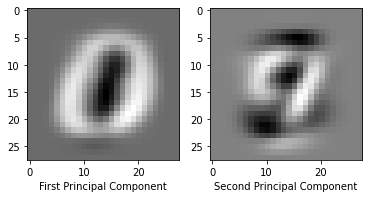

In [15]:
# Let's find the first 2 PCA components
num_components = 2
pca = PCA(n_components=num_components).fit(train_images)

# Reshape so they resemble images and we can print them
eigen_mnist = pca.components_.reshape(num_components, img_rows, img_cols)

# Show the reshaped principal components
f, ax = plt.subplots(1,2)
ax[0].imshow(eigen_mnist[0], cmap='gray')
ax[0].set_xlabel('First Principal Component')
ax[1].imshow(eigen_mnist[1], cmap='gray')
ax[1].set_xlabel('Second Principal Component')

In [16]:
# Print the variance explained by those components
ratio = pca.explained_variance_ratio_.sum()
print(f"The pourcentage of the explained variance by the 2 kept components : {(100*ratio).round(2)}%")

The pourcentage of the explained variance by the 2 kept components : 16.8%


Comment on the visualization in relation to the variance explained by only keeping the two principal components:
<div class='alert alert-block alert-warning'>
            Answer:</div>

The first image is supposed to be 0, and it can be seen relatively from the image. But in the second one we cannot recognize the digit since its form is more tricky. This is normal since the explained variance of these two components is not enough to reconstruct the original images.

### Implementing the Autoencoder with Keras

Now, we will use Keras to implement the autoencoder. You can take a look at this [cheatsheet](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Keras_Cheat_Sheet_Python.pdf) for some basic commands to use keras.

In this first case, we implement a **simple linear autoencoder**. Build it in order to have the same capacity as the PCA decomposition (2 hidden dimensions !) we made just above. 
<div class='alert alert-block alert-info'>
            Code:</div>

In [17]:
# Input layer
input_layer = Input(shape=(784,), name='input_layer')
# Encoding layer
latent_view = Dense(2, activation='linear', name='latent_view')(input_layer)
# Decoding layer
output_layer = Dense(784, activation='sigmoid', name='output_layer')(latent_view)

ae_model = Model(input_layer, output_layer, name='ae_model')
ae_model.summary()

Model: "ae_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 784)]             0         
                                                                 
 latent_view (Dense)         (None, 2)                 1570      
                                                                 
 output_layer (Dense)        (None, 784)               2352      
                                                                 
Total params: 3,922
Trainable params: 3,922
Non-trainable params: 0
_________________________________________________________________


What loss shoud we use ? Choose the usual one and import it directly from Keras. You can use a simple ```SGD``` optimizer, and then compile the model; finally, train it to rebuild images from the original examples. 


<div class='alert alert-block alert-info'>
            Code:</div>

In [18]:
from tensorflow.keras.losses import MeanSquaredError
loss = MeanSquaredError()

optimizer = SGD(lr=1e-1) 
ae_model.compile(optimizer=optimizer, loss=loss) 

batch_size = 128
epochs = 10
# No noise here - we want to train a simple auto-encoder and compare visually with PCA
history = ae_model.fit(train_images, train_images,
                       epochs=epochs,
                       batch_size=batch_size,
                       verbose=1,
                       shuffle=True,
                       validation_data=(test_images, test_images))

Epoch 1/10
469/469 [==============================] - 1s 2ms/step - loss: 1.2504 - val_loss: 1.2586
Epoch 2/10
469/469 [==============================] - 1s 1ms/step - loss: 1.2476 - val_loss: 1.2546
Epoch 3/10
469/469 [==============================] - 1s 2ms/step - loss: 1.2400 - val_loss: 1.2406
Epoch 4/10
469/469 [==============================] - 1s 1ms/step - loss: 1.2123 - val_loss: 1.1910
Epoch 5/10
469/469 [==============================] - 1s 2ms/step - loss: 1.1313 - val_loss: 1.0720
Epoch 6/10
469/469 [==============================] - 1s 2ms/step - loss: 0.9951 - val_loss: 0.9320
Epoch 7/10
469/469 [==============================] - 1s 1ms/step - loss: 0.8889 - val_loss: 0.8616
Epoch 8/10
469/469 [==============================] - 1s 2ms/step - loss: 0.8442 - val_loss: 0.8351
Epoch 9/10
469/469 [==============================] - 1s 2ms/step - loss: 0.8261 - val_loss: 0.8233
Epoch 10/10
469/469 [==============================] - 1s 2ms/step - loss: 0.8174 - val_loss: 0.8172

Assuming that the name of your layer (obtained through the command ```model.summary()```) is ```'layer'```, here is the way to obtained the weights. Visualize the weights of the encoder and compare them to the two components obtained through the PCA.

<div class='alert alert-block alert-info'>
            Code:</div>

Text(0.5, 0, 'Second Principal Component')

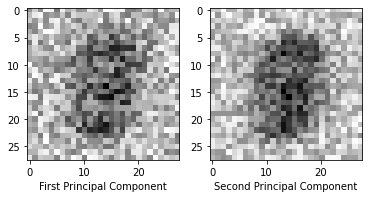

In [19]:
weights, bias = ae_model.get_layer('latent_view').get_weights()

# Show the reshaped principal components
f, ax = plt.subplots(1,2)
ax[0].imshow(weights[:,0].reshape(img_rows, img_cols), cmap='gray')
ax[0].set_xlabel('First Principal Component')
ax[1].imshow(weights[:, 1].reshape(img_rows, img_cols), cmap='gray')
ax[1].set_xlabel('Second Principal Component')

Now, visualize the images rebuilt by the network !
<div class='alert alert-block alert-info'>
            Code:</div>

313/313 [==============================] - 0s 623us/step


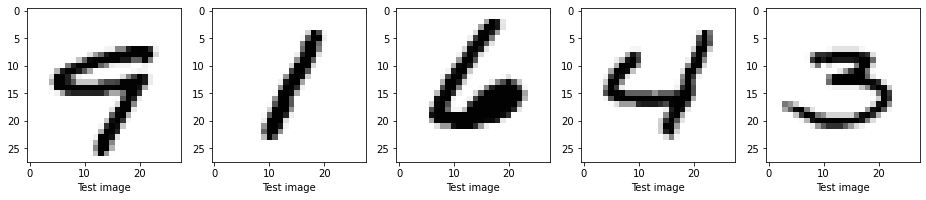

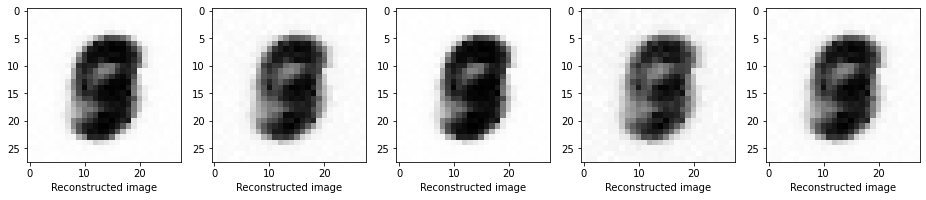

In [20]:
# Select a few images at random: look from n
n = np.random.randint(0,len(test_images)-5)

# Plot a few images from n  
f, ax = plt.subplots(1,5, figsize=(16, 6))
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(test_images[a].reshape(img_rows, img_cols), cmap='Greys')
    ax[i].set_xlabel('Test image')
    

# Get the prediction from the model 
pred = ae_model.predict(test_images)

f, ax = plt.subplots(1,5, figsize=(16, 6))
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(pred[a].reshape(img_rows, img_cols), cmap='Greys')
    ax[i].set_xlabel('Reconstructed image')

The reconstruction is not really convincing. But this was expected since, as for the PCA, we kept only 2 components in the encoding layer.

Do the same ( = build a new model) with a latent dimension that is largely higher than 2. Compare the visualizations and the images that are rebuilt. 
<div class='alert alert-block alert-info'>
            Code:</div>

In [21]:
# Input layer
input_layer = Input(shape=(784,), name='input_layer')
latent_view = Dense(128, activation='linear', name='latent_view')(input_layer)
output_layer = Dense(784, activation='linear', name='output_layer')(latent_view)
ae_model = Model(input_layer, output_layer, name='ae_model')

loss = MeanSquaredError()

optimizer = SGD(lr=1e-1) 
ae_model.compile(optimizer=optimizer, loss=loss) 

batch_size = 128
epochs = 10
history = ae_model.fit(train_images, train_images,
                       epochs=epochs,
                       batch_size=batch_size,
                       verbose=1,
                       shuffle=True,
                       validation_data=(test_images, test_images))

Epoch 1/10
469/469 [==============================] - 1s 2ms/step - loss: 1.0718 - val_loss: 0.8503
Epoch 2/10
469/469 [==============================] - 1s 2ms/step - loss: 0.7635 - val_loss: 0.7081
Epoch 3/10
469/469 [==============================] - 1s 2ms/step - loss: 0.6789 - val_loss: 0.6468
Epoch 4/10
469/469 [==============================] - 1s 2ms/step - loss: 0.6243 - val_loss: 0.5960
Epoch 5/10
469/469 [==============================] - 1s 2ms/step - loss: 0.5772 - val_loss: 0.5517
Epoch 6/10
469/469 [==============================] - 1s 2ms/step - loss: 0.5366 - val_loss: 0.5140
Epoch 7/10
469/469 [==============================] - 1s 2ms/step - loss: 0.5023 - val_loss: 0.4824
Epoch 8/10
469/469 [==============================] - 1s 2ms/step - loss: 0.4736 - val_loss: 0.4559
Epoch 9/10
469/469 [==============================] - 1s 2ms/step - loss: 0.4492 - val_loss: 0.4334
Epoch 10/10
469/469 [==============================] - 1s 2ms/step - loss: 0.4284 - val_loss: 0.4141

313/313 [==============================] - 0s 761us/step


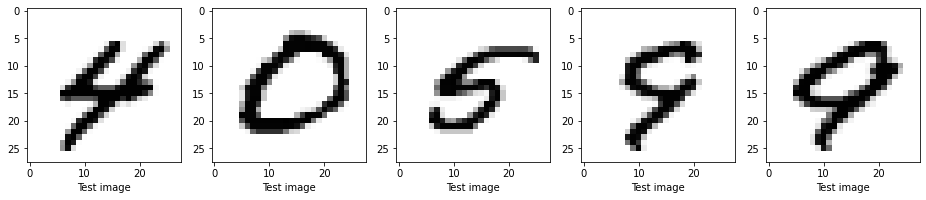

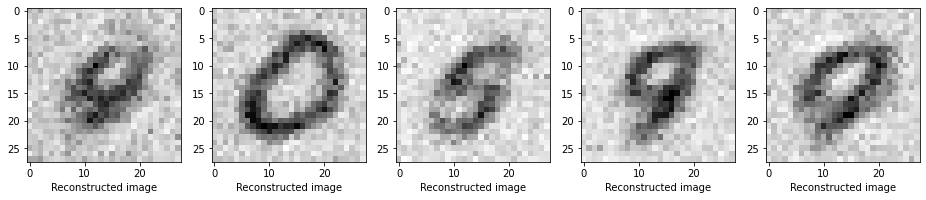

In [22]:
n = np.random.randint(0,len(test_images)-5)

# Plot a few images from n  
f, ax = plt.subplots(1,5, figsize=(16, 6))
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(test_images[a].reshape(img_rows, img_cols), cmap='Greys')
    ax[i].set_xlabel('Test image')
    

# Get the prediction from the model 
pred = ae_model.predict(test_images)

f, ax = plt.subplots(1,5, figsize=(16, 6))
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(pred[a].reshape(img_rows, img_cols), cmap='Greys')
    ax[i].set_xlabel('Reconstructed image')

Now we can recognize the reconstructed digits, but the images remain noisy. 

### Bonus: De-noising Autoencoder

Now, we can implement a **de-noising autoencoder**. The following function will transform an array of images by adding it random noise. Create a new autoencoder model, this time with **more layers** and **non-linear activations** (like the ReLU) and train it to rebuild the de-noised images. Display some testing images, with noise, and re-built.

In [23]:
def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """
    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )
    return noisy_array

<div class='alert alert-block alert-info'>
            Code:</div>

In [24]:
# Visualize some of the images with noise against the originals
n = np.random.randint(0,len(test_images)-5)

# Build a new model with more layers and Relu activations
input_layer = Input(shape=(img_cols*img_rows,))
encoder_1  = Dense(128, activation='relu')(input_layer)
encoder_2  = Dense(64, activation='relu')(encoder_1)
encoder_3  = Dense(32, activation='relu')(encoder_2)
decoder_1  = Dense(64, activation='relu')(encoder_3)
decoder_2  = Dense(128, activation='relu')(decoder_1)
decoder_3   = Dense(784, activation='sigmoid')(decoder_2)

denoising_encoder = Model(input_layer, decoder_3, name='denoising_encoder')

# Compile it but here, use noised data as inputs !
train_with_noise = noise(train_images)
test_with_noise = noise(test_images)

loss = MeanSquaredError()
optimizer = SGD(lr=1e-1) 
denoising_encoder.compile(optimizer='adam', loss=loss)

batch_size = 256
epochs = 20

history = denoising_encoder.fit(train_with_noise, 
                        train_images,
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=1,
                        shuffle=True,
                        validation_data=(test_with_noise, test_images))


Epoch 1/20
235/235 [==============================] - 2s 5ms/step - loss: 0.7484 - val_loss: 0.6854
Epoch 2/20
235/235 [==============================] - 1s 4ms/step - loss: 0.6594 - val_loss: 0.6472
Epoch 3/20
235/235 [==============================] - 1s 5ms/step - loss: 0.6307 - val_loss: 0.6214
Epoch 4/20
235/235 [==============================] - 1s 4ms/step - loss: 0.6083 - val_loss: 0.6035
Epoch 5/20
235/235 [==============================] - 1s 5ms/step - loss: 0.5946 - val_loss: 0.5917
Epoch 6/20
235/235 [==============================] - 1s 5ms/step - loss: 0.5834 - val_loss: 0.5822
Epoch 7/20
235/235 [==============================] - 1s 4ms/step - loss: 0.5758 - val_loss: 0.5759
Epoch 8/20
235/235 [==============================] - 1s 4ms/step - loss: 0.5693 - val_loss: 0.5700
Epoch 9/20
235/235 [==============================] - 1s 5ms/step - loss: 0.5640 - val_loss: 0.5660
Epoch 10/20
235/235 [==============================] - 1s 5ms/step - loss: 0.5602 - val_loss: 0.5631

313/313 [==============================] - 0s 968us/step


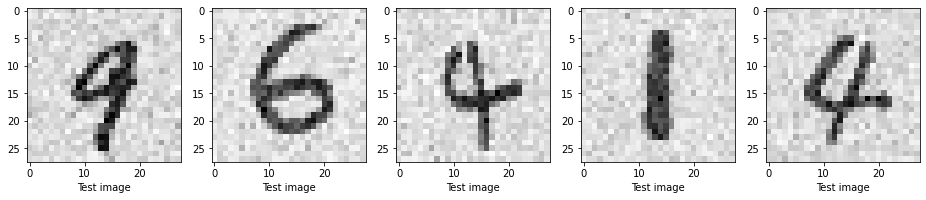

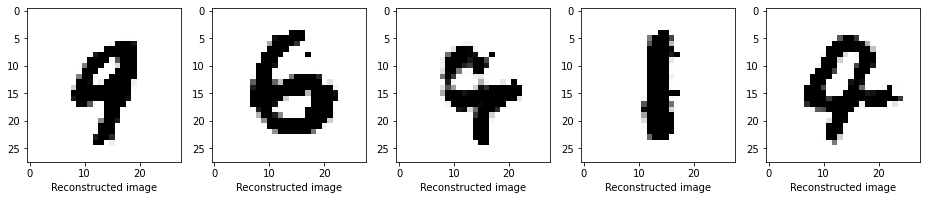

In [25]:
n = np.random.randint(0,len(test_images)-5)

# Plot a few images from n  
f, ax = plt.subplots(1,5, figsize=(16, 6))
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(test_with_noise[a].reshape(img_rows, img_cols), cmap='Greys')
    ax[i].set_xlabel('Test image')
    

# Get the prediction from the model 
pred = denoising_encoder.predict(test_images)

f, ax = plt.subplots(1,5, figsize=(16, 6))
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(pred[a].reshape(img_rows, img_cols), cmap='Greys')
    ax[i].set_xlabel('Reconstructed image')

This is quite satisfying as result. 
Note the use of *'Adam'* as optimizer in order to accelerate the convergence process and get a faster convergence and better generalization performance compared to SGD.

Assuming that we normalize the images to be in the 0-1 range, what other loss function could we use ?
<div class='alert alert-block alert-warning'>
            Answer:</div>

We can use the negative log-likelihood as loss to minimize the softmax as a probabilistic interpretation.